# Image search using SIFT

We can find images similar to a query in a fast way (faster than doing pair-wise comparison with all images in a database). One way to do this is to find special points of interest in every image, so called keypoints (or descriptors), which characterize the image and which are more or less invariant to scaling, orientation, illumination changes, and some other distortions. There are several algorithms available that identify such keypoints, and today we will focus on [SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). 

## Data

We will use Caltech 101 dataset, download it from [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). It consists of pictures of objects belonging to 101 categories. About 40 to 800 images per category. Most categories have about 50 images. The size of each image is roughly 300 x 200 pixels.

## SIFT example

Below is an example how to extract SIFT keyponts using `opencv`. [This](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html) is a dedicated tutorial, and [this](https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html) is another tutorial you may need to find matches between two images.

In [1]:
# !pip install opencv-python==3.4.2.17
# !pip install opencv-contrib-python==3.4.2.17

In [2]:
import cv2 as cv
from matplotlib import pyplot as plt

img_dir = '101_ObjectCategories'
# Image that is not detectable by the SIFT
img = cv.imread(img_dir + '/BACKGROUND_Google/image_0031.jpg')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
kp = sift.detect(img,None)
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

## Task 1. Index keypoints

Let's suppose we've found image descriptors. How do we find similar images, having this information? In our case the descriptors are 128-dinensional vectors per keypoint, and there can be hundreds of such points. To enable fast search of similar images, we will index descriptors of all images using some datastructure for approximate nearest neighbors search, such as Navigable Small World or Annoy. Then, for a query image we generate its descriptors, and for each of them find its k nearest neighbors (using Euclidean or Cosine distance). Finally, we sort potential similar images (retrieved from neighbor descriptors) by frequency with which they appear in k nearest neighbors.



Read all images, saving category information. For every image generate SIFT descriptors and index them using some datastructure for inexact nearest neighbors search, e.g., HNSW from [`nmslib`](https://github.com/nmslib/nmslib).

In [3]:
# TODO: read all images, generate its descriptors and index them
# You may face computational problems due to large number of descriptors.
# To mitigate it, pick only top_k descriptors for each image, sorted by 
# "response" attribute of a KeyPoint object, which reflects the "goodness" of a point
import os
import numpy as np
import time
from annoy import AnnoyIndex

top_k = 15         # num of key points inside each descriptor. The more, the better final accuracy.
des_to_img = {}    # match descriptor with image by id. Contains category and path of image.
descriptors = []   # descriptors extracted from each image.
categories = []    # just list of all categories for convenience


def get_keypoints_and_des(img, top_k):
    """Get top_k keypoints of image and descriptor constructed from it"""
    kp = sift.detect(img, None)
    kp = sorted(kp, key=lambda point: point.response, reverse=True)[:top_k]
    return sift.compute(img, kp)
    

def extract_image_descriptors(img_dir):
    """parse provided img_dir directory, 
    extract top_k key_point, and create descriptors from it.
    """
    image_id = 0
    start = time.time()
    for cat_num, img_cat_dir in enumerate(os.scandir(img_dir)):
        categories.append(img_cat_dir.name)

        if (cat_num + 1) % 10 == 0:
            print(f'{(cat_num + 1)}% is processed, {round(time.time() - start)} sec. spent overall')

        for i, image_info in enumerate(os.scandir(img_cat_dir)):
            kp, des = get_keypoints_and_des(cv.imread(image_info.path), top_k)

            if des is None:  # in case of some troubles with image processing - omit img.
                print(f"Image file {image_info.path} in category {img_cat_dir.name} has None descriptor!")
                continue
            descriptors.append(des)

            des_to_img[image_id] = (img_cat_dir.name, image_info.path)
            image_id += 1

extract_image_descriptors(img_dir)
print("\n", f"Overall {len(descriptors)} descriptors are extracted")
print(f"Each descriptor has a shape of {descriptors[0].shape}")

10% is processed, 41 sec. spent overall
20% is processed, 62 sec. spent overall
30% is processed, 82 sec. spent overall
40% is processed, 100 sec. spent overall
50% is processed, 135 sec. spent overall
60% is processed, 149 sec. spent overall
70% is processed, 169 sec. spent overall
Image file 101_ObjectCategories/BACKGROUND_Google/image_0031.jpg in category BACKGROUND_Google has None descriptor!
80% is processed, 224 sec. spent overall
90% is processed, 260 sec. spent overall
100% is processed, 300 sec. spent overall

 Overall 9144 descriptors are extracted
Each descriptor has a shape of (15, 128)


In [4]:
vecId_to_desId = [] # contains items in format: (last_vectorId_of_the_descriptor, descId). 

def build_annoy_index(descriptors, KEY_POINT_LENGTH):
    """Index all the key point vectors with AnnoyIndex"""
    index = AnnoyIndex(KEY_POINT_LENGTH, 'euclidean')
    for des_id, des in enumerate(descriptors):
        for j, vector in enumerate(des):
            vector_id = des_id*len(des) + j
            index.add_item(vector_id, vector)
            if j == len(des) - 1:
                # keep the id of the last vector of the descriptor for the result matching
                vecId_to_desId.append((vector_id, des_id)) 

    index.build(10) # number of trees
    return index

index = build_annoy_index(descriptors, 128)

In [5]:
import time

# contains number of times concrete descriptor is found 
# as nearest to the request vector for each category.
images_frequencies = {}


def get_image_path(des_id):
    """Return image path by provided descriptorId"""
    return des_to_img[des_id][1]


def find_nearest_images_for_each_category(index):
    """Take the 1st image from each category in the dataset 
    as the request one and finds most similar images to it
    using provided AnnoyIndex.
    """
    start = time.time()
    for cat_num, category in enumerate(categories):
        # iterate by all the categories in the dataset
        images_frequencies[category] = {}
        query_path = img_dir + f'/{category}/image_0001.jpg'
        _, query_des = get_keypoints_and_des(cv.imread(query_path), top_k)

        # iterate over desc. vectors of the request image
        for i, vector in enumerate(query_des):
            best_vector_ids = index.get_nns_by_vector(vector, 15)
            for best_vec_id in best_vector_ids:
                for vec_id, des_id in vecId_to_desId:
                    # find descriptorId, which contains Id of the found nearest vector.
                    # omit query image descriptor
                    if best_vec_id <= vec_id and query_path != get_image_path(des_id):
                        if des_id not in images_frequencies[category]:
                            images_frequencies[category][des_id] = 1
                        else: # remember descriptors that contain nearest vectors.
                            images_frequencies[category][des_id] += 1
                        break
    print(f'{round(time.time() - start)} sec. spent to process all requests')

find_nearest_images_for_each_category(index)

7 sec. spent to process all requests


## Task 2. Find similar and evaluate

Now, having index calculated, let's pick **one image from each category** (**the first one**, for sync), and find its **10** most similar images among all images.

If a similar image belongs to the same category, it considers as a hit. At last, compute and print the accuracy - the number of hits over total possible number of hits.

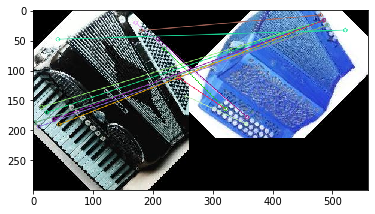

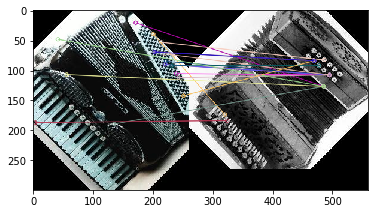

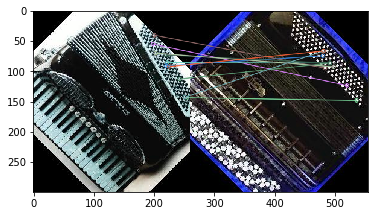

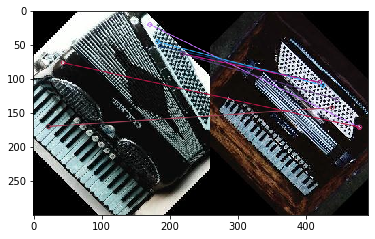

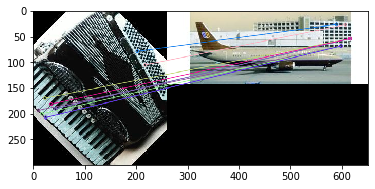

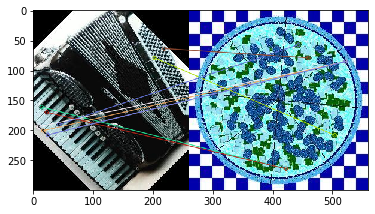

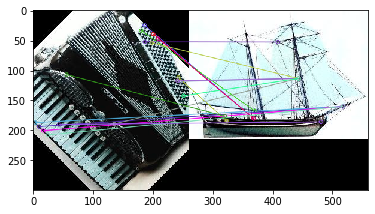

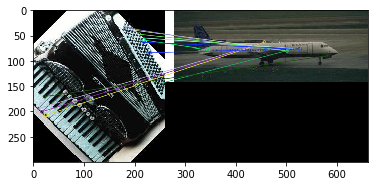

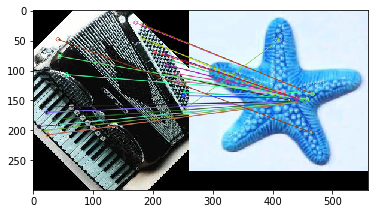

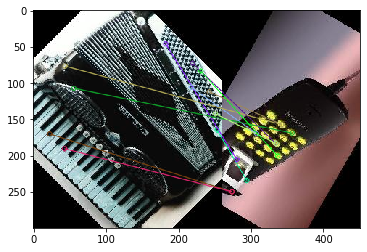

accuracy 0.17254901960784313


In [6]:
# TODO: find top 10 similar images for the first image of each category
# output results for the "accordion" category and calculate final accuracy

def plot_key_points_matching(query_img, cand_image):
    """plots provided images and key points 
    matching between them.
    """
    # take more key points for better visualization.
    query_kp, query_des = get_keypoints_and_des(query_img, top_k * 4) 
    kp, des = get_keypoints_and_des(cand_image, top_k * 4)
    
    # find and select good matches:
    bf = cv.BFMatcher()
    matches = bf.knnMatch(query_des, des, k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.95*n.distance:
            good.append([m])
    
    # draw matching picture:
    img = cv.drawMatchesKnn(query_img, query_kp, cand_image, kp, good, None, 
                            flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img)
    plt.show()

    
def calculate_accuracy_and_plot(images_frequencies, 
                                cat_to_show='accordion'):
    """Calculate accuracy of hits and plot key points matching
    for the chosen category.
    
    images_frequencies - dict by each category with info about 
    number of times nearest vectors of the request descriptor
    were found in other descriptors.
    images_frequencies[category][des_id] = num_of_matchings
    """
    query_img_path = img_dir + f'/{cat_to_show}/image_0001.jpg'
    total_hits = 0
    for query_cat, candidates in images_frequencies.items():
        if query_cat == cat_to_show:
            query_img = cv.imread(query_img_path)
            
        top_descs = [
            k for k, _ in sorted(candidates.items(), key=lambda item: item[1], reverse=True)
        ]
        for des_id in top_descs[:10]:
            candidate_cat = des_to_img[des_id][0]
            if query_cat == candidate_cat:
                total_hits += 1
            
            if query_cat == cat_to_show:
                cand_image = cv.imread(get_image_path(des_id))
                plot_key_points_matching(query_img, cand_image)
    
    # total number of hits divided by number of cat-s * num of 
    # considered images in each.
    return total_hits / (len(images_frequencies) * 10)

print("accuracy", calculate_accuracy_and_plot(images_frequencies))